In [1]:
trial_number_ml = "004"
random_state_init = 444

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n


In [4]:
def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model1_files = ['../../data_for_ml/ml_datasets_set2/model1_rna_bin_non_rna_bin/data.pkl']

# Load datasets
model1_df = load_and_concatenate_datasets(model1_files)

# Preprocess datasets
X1, y1 = preprocess_data(model1_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X1, y1)

# Output shapes
print(f"Model 1 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 1 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 15:52:32,283] A new study created in memory with name: no-name-6a3ab0af-dbe1-4421-b060-23c77a6e976b


[I 2024-05-01 15:53:13,863] Trial 3 finished with value: 0.6181132477981288 and parameters: {'n_estimators': 188, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.6181132477981288.


[I 2024-05-01 15:53:18,315] Trial 1 finished with value: 0.6161988642712746 and parameters: {'n_estimators': 255, 'max_depth': 81, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 3 with value: 0.6181132477981288.


[I 2024-05-01 15:53:53,267] Trial 0 finished with value: 0.6152424344009997 and parameters: {'n_estimators': 447, 'max_depth': 100, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 3 with value: 0.6181132477981288.


[I 2024-05-01 15:54:08,601] Trial 4 finished with value: 0.6279909385507777 and parameters: {'n_estimators': 270, 'max_depth': 95, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 4 with value: 0.6279909385507777.


[I 2024-05-01 15:54:25,724] Trial 2 finished with value: 0.6267175611292273 and parameters: {'n_estimators': 437, 'max_depth': 96, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.6279909385507777.


[I 2024-05-01 15:54:50,620] Trial 5 finished with value: 0.634053576326456 and parameters: {'n_estimators': 322, 'max_depth': 90, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.634053576326456.


[I 2024-05-01 15:55:02,491] Trial 7 pruned. 


[I 2024-05-01 15:56:29,795] Trial 8 finished with value: 0.6212928818862442 and parameters: {'n_estimators': 664, 'max_depth': 97, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 5 with value: 0.634053576326456.


[I 2024-05-01 15:56:31,976] Trial 10 pruned. 


[I 2024-05-01 15:56:47,333] Trial 9 finished with value: 0.6251191092961124 and parameters: {'n_estimators': 637, 'max_depth': 43, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 5 with value: 0.634053576326456.


[I 2024-05-01 15:57:05,852] Trial 12 pruned. 


[I 2024-05-01 15:57:09,418] Trial 6 finished with value: 0.6302248092727476 and parameters: {'n_estimators': 764, 'max_depth': 82, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.634053576326456.


[I 2024-05-01 15:57:10,840] Trial 14 pruned. 


[I 2024-05-01 15:57:53,007] Trial 15 pruned. 


[I 2024-05-01 15:57:53,959] Trial 11 pruned. 


[I 2024-05-01 15:59:45,467] Trial 13 finished with value: 0.6362788122593688 and parameters: {'n_estimators': 803, 'max_depth': 69, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.6362788122593688.


[I 2024-05-01 16:00:17,840] Trial 16 finished with value: 0.631498186694298 and parameters: {'n_estimators': 860, 'max_depth': 71, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.6362788122593688.


[I 2024-05-01 16:00:30,804] Trial 17 finished with value: 0.6295822793811396 and parameters: {'n_estimators': 739, 'max_depth': 77, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.6362788122593688.


[I 2024-05-01 16:00:43,369] Trial 18 finished with value: 0.6314941232641533 and parameters: {'n_estimators': 786, 'max_depth': 73, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.6362788122593688.


[I 2024-05-01 16:00:58,132] Trial 22 pruned. 


[I 2024-05-01 16:01:18,606] Trial 20 pruned. 


[I 2024-05-01 16:01:59,266] Trial 21 pruned. 


[I 2024-05-01 16:02:22,404] Trial 23 pruned. 


[I 2024-05-01 16:02:36,884] Trial 19 finished with value: 0.632454616564573 and parameters: {'n_estimators': 776, 'max_depth': 50, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.6362788122593688.


[I 2024-05-01 16:03:04,909] Trial 26 pruned. 


[I 2024-05-01 16:04:45,749] Trial 27 finished with value: 0.6385136988388748 and parameters: {'n_estimators': 528, 'max_depth': 34, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.6385136988388748.


[I 2024-05-01 16:05:04,731] Trial 24 finished with value: 0.632133605583153 and parameters: {'n_estimators': 924, 'max_depth': 65, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.6385136988388748.


[I 2024-05-01 16:05:10,113] Trial 28 finished with value: 0.6356439012992818 and parameters: {'n_estimators': 533, 'max_depth': 30, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.6385136988388748.


[I 2024-05-01 16:05:53,704] Trial 30 pruned. 


[I 2024-05-01 16:05:57,075] Trial 25 finished with value: 0.6375572689685999 and parameters: {'n_estimators': 914, 'max_depth': 67, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.6385136988388748.


[I 2024-05-01 16:06:21,086] Trial 29 pruned. 


[I 2024-05-01 16:06:30,727] Trial 33 pruned. 


[I 2024-05-01 16:06:39,892] Trial 34 pruned. 


[I 2024-05-01 16:07:08,035] Trial 36 pruned. 


[I 2024-05-01 16:07:17,127] Trial 31 finished with value: 0.6388331860339906 and parameters: {'n_estimators': 534, 'max_depth': 28, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 31 with value: 0.6388331860339906.


[I 2024-05-01 16:07:32,662] Trial 38 pruned. 


[I 2024-05-01 16:07:36,808] Trial 32 finished with value: 0.6362818598319772 and parameters: {'n_estimators': 438, 'max_depth': 30, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 31 with value: 0.6388331860339906.


[I 2024-05-01 16:07:47,146] Trial 37 pruned. 


[I 2024-05-01 16:07:57,425] Trial 40 pruned. 


[I 2024-05-01 16:08:04,598] Trial 42 pruned. 


[I 2024-05-01 16:08:05,333] Trial 35 finished with value: 0.6330915592397323 and parameters: {'n_estimators': 427, 'max_depth': 25, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 31 with value: 0.6388331860339906.


[I 2024-05-01 16:08:34,270] Trial 44 pruned. 


[I 2024-05-01 16:08:53,379] Trial 45 pruned. 


[I 2024-05-01 16:09:23,922] Trial 46 pruned. 


[I 2024-05-01 16:09:28,353] Trial 41 finished with value: 0.6356418695842094 and parameters: {'n_estimators': 412, 'max_depth': 38, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 31 with value: 0.6388331860339906.


[I 2024-05-01 16:09:42,236] Trial 47 pruned. 


[I 2024-05-01 16:09:51,489] Trial 39 finished with value: 0.6369177866496003 and parameters: {'n_estimators': 599, 'max_depth': 36, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 31 with value: 0.6388331860339906.


[I 2024-05-01 16:09:55,090] Trial 48 pruned. 


[I 2024-05-01 16:10:01,124] Trial 49 pruned. 


[I 2024-05-01 16:10:03,420] Trial 43 finished with value: 0.6337285019148915 and parameters: {'n_estimators': 596, 'max_depth': 37, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 31 with value: 0.6388331860339906.


Best trial for RandomForestClassifier:
  Value: 0.6388331860339906
  Params: 
    n_estimators: 534
    max_depth: 28
    min_samples_split: 14
    min_samples_leaf: 1
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 534, 'max_depth': 28, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2024-05-01 16:10:12,565] A new study created in memory with name: no-name-7cc1a9d1-55d0-48eb-802e-2ec4fb35c34a


RandomForestClassifier accuracy: 0.6089



[I 2024-05-01 16:10:27,454] Trial 1 finished with value: 0.6136485539267973 and parameters: {'n_estimators': 125, 'max_depth': 8, 'learning_rate': 0.1327307810193908, 'min_child_weight': 10, 'subsample': 0.8819632122842946, 'colsample_bytree': 0.7952701791432446, 'gamma': 4.394807035580591, 'reg_lambda': 1.886455816718201, 'reg_alpha': 0.25381981309746404}. Best is trial 1 with value: 0.6136485539267973.


[I 2024-05-01 16:10:28,975] Trial 3 finished with value: 0.619377990430622 and parameters: {'n_estimators': 102, 'max_depth': 6, 'learning_rate': 0.15801250576951284, 'min_child_weight': 8, 'subsample': 0.5003019016844295, 'colsample_bytree': 0.6951070369511387, 'gamma': 3.7346934304846755, 'reg_lambda': 4.120537485962148, 'reg_alpha': 0.01699251304161417}. Best is trial 3 with value: 0.619377990430622.


[I 2024-05-01 16:10:36,454] Trial 2 finished with value: 0.6111023070124647 and parameters: {'n_estimators': 217, 'max_depth': 3, 'learning_rate': 0.029735860490826986, 'min_child_weight': 6, 'subsample': 0.7029770355765306, 'colsample_bytree': 0.8396870304810657, 'gamma': 4.849285946766688, 'reg_lambda': 0.9563871668017813, 'reg_alpha': 0.06414851715742675}. Best is trial 3 with value: 0.619377990430622.


[I 2024-05-01 16:10:56,470] Trial 0 finished with value: 0.6107757088145959 and parameters: {'n_estimators': 545, 'max_depth': 5, 'learning_rate': 0.17690676589092202, 'min_child_weight': 7, 'subsample': 0.7059392313135123, 'colsample_bytree': 0.7899055656394711, 'gamma': 2.739708691454588, 'reg_lambda': 0.03702280989663505, 'reg_alpha': 3.9830807386667177}. Best is trial 3 with value: 0.619377990430622.


[I 2024-05-01 16:11:26,427] Trial 4 finished with value: 0.6095028393218136 and parameters: {'n_estimators': 844, 'max_depth': 5, 'learning_rate': 0.22578174177717308, 'min_child_weight': 6, 'subsample': 0.964795717000564, 'colsample_bytree': 0.9444709213384037, 'gamma': 4.864329780284557, 'reg_lambda': 0.3235203615084605, 'reg_alpha': 0.011638701242842872}. Best is trial 3 with value: 0.619377990430622.


[I 2024-05-01 16:11:26,469] Trial 5 pruned. 


[I 2024-05-01 16:11:32,835] Trial 9 pruned. 


[I 2024-05-01 16:11:37,369] Trial 8 pruned. 


[I 2024-05-01 16:11:38,978] Trial 11 pruned. 


[I 2024-05-01 16:11:41,789] Trial 10 pruned. 


[I 2024-05-01 16:12:05,762] Trial 13 finished with value: 0.6136434746391166 and parameters: {'n_estimators': 166, 'max_depth': 8, 'learning_rate': 0.23604291217682177, 'min_child_weight': 8, 'subsample': 0.5025920788312819, 'colsample_bytree': 0.6815090925895247, 'gamma': 1.9553580322450264, 'reg_lambda': 6.859219347052209, 'reg_alpha': 0.010151628967110747}. Best is trial 3 with value: 0.619377990430622.


[I 2024-05-01 16:12:07,254] Trial 12 finished with value: 0.6177891892441003 and parameters: {'n_estimators': 294, 'max_depth': 5, 'learning_rate': 0.0557620958430533, 'min_child_weight': 1, 'subsample': 0.7739132633515953, 'colsample_bytree': 0.715603070908716, 'gamma': 3.1468962419192668, 'reg_lambda': 0.6884672470693054, 'reg_alpha': 0.21552263945773567}. Best is trial 3 with value: 0.619377990430622.


[I 2024-05-01 16:12:08,161] Trial 14 pruned. 


[I 2024-05-01 16:12:12,282] Trial 7 finished with value: 0.6212949136013165 and parameters: {'n_estimators': 589, 'max_depth': 9, 'learning_rate': 0.021017074488685485, 'min_child_weight': 3, 'subsample': 0.5895298894362309, 'colsample_bytree': 0.5480945667357309, 'gamma': 1.978225439361676, 'reg_lambda': 1.249035066574163, 'reg_alpha': 0.09375297830598275}. Best is trial 7 with value: 0.6212949136013165.


[I 2024-05-01 16:12:17,063] Trial 17 pruned. 


[I 2024-05-01 16:12:21,223] Trial 18 pruned. 


[I 2024-05-01 16:12:26,935] Trial 16 finished with value: 0.6267165452716912 and parameters: {'n_estimators': 377, 'max_depth': 6, 'learning_rate': 0.035118764104578065, 'min_child_weight': 1, 'subsample': 0.5113561315744827, 'colsample_bytree': 0.6282976331103097, 'gamma': 2.908498443480256, 'reg_lambda': 2.854619473877252, 'reg_alpha': 0.26938940956249485}. Best is trial 16 with value: 0.6267165452716912.


[I 2024-05-01 16:12:27,826] Trial 15 finished with value: 0.6279960178384584 and parameters: {'n_estimators': 374, 'max_depth': 7, 'learning_rate': 0.014509054294683132, 'min_child_weight': 1, 'subsample': 0.5165984423161678, 'colsample_bytree': 0.6511270972220149, 'gamma': 3.4413256720899743, 'reg_lambda': 2.4507626124593855, 'reg_alpha': 0.5920370020721256}. Best is trial 15 with value: 0.6279960178384584.


[I 2024-05-01 16:12:28,781] Trial 19 pruned. 


[I 2024-05-01 16:12:29,847] Trial 6 finished with value: 0.6273550117331546 and parameters: {'n_estimators': 836, 'max_depth': 9, 'learning_rate': 0.027446373874051543, 'min_child_weight': 1, 'subsample': 0.7714871621539072, 'colsample_bytree': 0.6345000436410739, 'gamma': 0.171637025468655, 'reg_lambda': 0.6331081352464156, 'reg_alpha': 0.18294102867488596}. Best is trial 15 with value: 0.6279960178384584.


[I 2024-05-01 16:12:31,718] Trial 21 pruned. 


[I 2024-05-01 16:12:34,320] Trial 22 pruned. 


[I 2024-05-01 16:12:36,328] Trial 23 pruned. 


[I 2024-05-01 16:12:39,553] Trial 20 pruned. 


[I 2024-05-01 16:12:39,573] Trial 25 pruned. 


[I 2024-05-01 16:12:42,737] Trial 24 pruned. 


[I 2024-05-01 16:12:43,812] Trial 28 pruned. 


[I 2024-05-01 16:12:45,431] Trial 29 pruned. 


[I 2024-05-01 16:12:46,818] Trial 27 pruned. 


[I 2024-05-01 16:12:47,490] Trial 30 pruned. 


[I 2024-05-01 16:12:51,202] Trial 33 pruned. 


[I 2024-05-01 16:12:55,509] Trial 31 finished with value: 0.6174681782626804 and parameters: {'n_estimators': 171, 'max_depth': 6, 'learning_rate': 0.10424921163229565, 'min_child_weight': 4, 'subsample': 0.5365050703453801, 'colsample_bytree': 0.7446314110312102, 'gamma': 3.9519142503545295, 'reg_lambda': 1.8626832380964853, 'reg_alpha': 0.13999649023318853}. Best is trial 15 with value: 0.6279960178384584.


[I 2024-05-01 16:13:08,868] Trial 26 pruned. 


[I 2024-05-01 16:13:09,930] Trial 35 pruned. 


[I 2024-05-01 16:13:16,253] Trial 36 pruned. 


[I 2024-05-01 16:13:21,247] Trial 32 finished with value: 0.6184241002041875 and parameters: {'n_estimators': 541, 'max_depth': 6, 'learning_rate': 0.07342303124872418, 'min_child_weight': 4, 'subsample': 0.7049699604483824, 'colsample_bytree': 0.7799454385289745, 'gamma': 2.605273980021714, 'reg_lambda': 2.1232463982580825, 'reg_alpha': 0.13757489396617975}. Best is trial 15 with value: 0.6279960178384584.


[I 2024-05-01 16:13:23,767] Trial 37 pruned. 


[I 2024-05-01 16:13:26,678] Trial 39 pruned. 


[I 2024-05-01 16:13:30,753] Trial 34 finished with value: 0.6200215361797661 and parameters: {'n_estimators': 568, 'max_depth': 10, 'learning_rate': 0.03563503962962539, 'min_child_weight': 3, 'subsample': 0.6388006873809475, 'colsample_bytree': 0.5015025572077993, 'gamma': 1.889405953818373, 'reg_lambda': 1.0605831223561686, 'reg_alpha': 0.1040651125269847}. Best is trial 15 with value: 0.6279960178384584.


[I 2024-05-01 16:13:31,798] Trial 40 pruned. 


[I 2024-05-01 16:13:32,619] Trial 41 pruned. 


[I 2024-05-01 16:13:32,973] Trial 38 pruned. 


[I 2024-05-01 16:13:36,498] Trial 43 pruned. 


[I 2024-05-01 16:13:38,769] Trial 42 pruned. 


[I 2024-05-01 16:13:39,688] Trial 44 pruned. 


[I 2024-05-01 16:13:46,883] Trial 45 pruned. 


[I 2024-05-01 16:13:51,015] Trial 46 pruned. 


[I 2024-05-01 16:13:51,038] Trial 49 pruned. 


[I 2024-05-01 16:13:51,887] Trial 48 pruned. 


[I 2024-05-01 16:13:52,393] Trial 47 pruned. 


Best trial for XGBClassifier:
  Value: 0.6279960178384584
  Params: 
    n_estimators: 374
    max_depth: 7
    learning_rate: 0.014509054294683132
    min_child_weight: 1
    subsample: 0.5165984423161678
    colsample_bytree: 0.6511270972220149
    gamma: 3.4413256720899743
    reg_lambda: 2.4507626124593855
    reg_alpha: 0.5920370020721256

Best hyperparameters for XGBClassifier: {'n_estimators': 374, 'max_depth': 7, 'learning_rate': 0.014509054294683132, 'min_child_weight': 1, 'subsample': 0.5165984423161678, 'colsample_bytree': 0.6511270972220149, 'gamma': 3.4413256720899743, 'reg_lambda': 2.4507626124593855, 'reg_alpha': 0.5920370020721256}


[I 2024-05-01 16:15:46,043] A new study created in memory with name: no-name-5c2c7ad2-7df6-49d8-bf2d-7a923f073e68


XGBClassifier accuracy: 0.6115



[I 2024-05-01 16:15:46,908] Trial 3 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 96, 'max_depth': 8, 'learning_rate': 0.30003876022990783, 'n_estimators': 960, 'min_child_weight': 0.007454636656016451, 'min_child_samples': 1594, 'subsample': 0.9625927882067637, 'colsample_bytree': 0.8051520741343102, 'reg_alpha': 8.955469157116563e-05, 'reg_lambda': 1.4228723284753686e-06}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 16:15:48,926] Trial 4 finished with value: 0.506534503601215 and parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'max_depth': -1, 'learning_rate': 0.011440789169890778, 'n_estimators': 304, 'min_child_weight': 0.011385808664316736, 'min_child_samples': 1205, 'subsample': 0.8830977990511376, 'colsample_bytree': 0.8102865972111273, 'reg_alpha': 8.37766126399341e-06, 'reg_lambda': 9.662629141363858e-06}. Best is trial 4 with value: 0.506534503601215.


[I 2024-05-01 16:15:49,392] Trial 0 finished with value: 0.5871981633295746 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'max_depth': 4, 'learning_rate': 0.4202992458599154, 'n_estimators': 846, 'min_child_weight': 0.0012232172051023608, 'min_child_samples': 795, 'subsample': 0.8391098813189548, 'colsample_bytree': 0.9207056060910863, 'reg_alpha': 0.0006457849662755862, 'reg_lambda': 0.006861624284594905}. Best is trial 0 with value: 0.5871981633295746.


[I 2024-05-01 16:15:50,793] Trial 5 finished with value: 0.6082309856865672 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 2, 'learning_rate': 0.322755296836527, 'n_estimators': 154, 'min_child_weight': 0.06800090296951881, 'min_child_samples': 97, 'subsample': 0.9547576243021461, 'colsample_bytree': 0.9050503102517745, 'reg_alpha': 0.7134532078854715, 'reg_lambda': 0.00011253578398032564}. Best is trial 5 with value: 0.6082309856865672.


[I 2024-05-01 16:15:51,672] Trial 6 finished with value: 0.5779538597507086 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'max_depth': 9, 'learning_rate': 0.41114885533296097, 'n_estimators': 603, 'min_child_weight': 0.0013416026071764874, 'min_child_samples': 848, 'subsample': 0.9216964248248917, 'colsample_bytree': 0.8914848462114447, 'reg_alpha': 0.12508901378694162, 'reg_lambda': 1.0130844074784204e-07}. Best is trial 5 with value: 0.6082309856865672.


[I 2024-05-01 16:15:52,705] Trial 1 finished with value: 0.5951619784841374 and parameters: {'boosting_type': 'goss', 'num_leaves': 94, 'max_depth': 8, 'learning_rate': 0.022092261869405622, 'n_estimators': 949, 'min_child_weight': 0.0027185040893810955, 'min_child_samples': 254, 'subsample': 0.841520562070495, 'colsample_bytree': 0.9125693448582097, 'reg_alpha': 0.0025954494534374873, 'reg_lambda': 5.724595334425362e-07}. Best is trial 5 with value: 0.6082309856865672.


[I 2024-05-01 16:15:53,085] Trial 7 pruned. 


[I 2024-05-01 16:15:53,513] Trial 2 pruned. 


[I 2024-05-01 16:15:53,744] Trial 11 pruned. 


[I 2024-05-01 16:15:53,938] Trial 12 pruned. 


[I 2024-05-01 16:15:55,128] Trial 13 finished with value: 0.6095124899684068 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': 3, 'learning_rate': 0.2903898211932609, 'n_estimators': 102, 'min_child_weight': 0.030359664892902906, 'min_child_samples': 364, 'subsample': 0.9987499306131885, 'colsample_bytree': 0.8597963607836928, 'reg_alpha': 0.2687304977590963, 'reg_lambda': 0.000622659513013476}. Best is trial 13 with value: 0.6095124899684068.


[I 2024-05-01 16:15:55,683] Trial 9 pruned. 


[I 2024-05-01 16:15:56,957] Trial 14 finished with value: 0.60566492955028 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'max_depth': 3, 'learning_rate': 0.2971467940314706, 'n_estimators': 137, 'min_child_weight': 0.030433055459653895, 'min_child_samples': 73, 'subsample': 0.996449821675108, 'colsample_bytree': 0.8511262426565054, 'reg_alpha': 0.44724169178581735, 'reg_lambda': 0.0007088490650904617}. Best is trial 13 with value: 0.6095124899684068.


[I 2024-05-01 16:15:57,384] Trial 15 finished with value: 0.6079064192037709 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': 3, 'learning_rate': 0.35107503655627814, 'n_estimators': 129, 'min_child_weight': 0.03222886809428615, 'min_child_samples': 95, 'subsample': 0.9988407389619051, 'colsample_bytree': 0.867800683975782, 'reg_alpha': 0.8106877888254708, 'reg_lambda': 0.00013037265720874388}. Best is trial 13 with value: 0.6095124899684068.


[I 2024-05-01 16:15:57,678] Trial 16 pruned. 


[I 2024-05-01 16:15:58,580] Trial 8 pruned. 


[I 2024-05-01 16:15:59,615] Trial 18 finished with value: 0.6018554637897581 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': -1, 'learning_rate': 0.19143986323538098, 'n_estimators': 316, 'min_child_weight': 0.0540964747640858, 'min_child_samples': 455, 'subsample': 0.9395848741257342, 'colsample_bytree': 0.9477166906832094, 'reg_alpha': 0.020703478973086133, 'reg_lambda': 0.3177109216674307}. Best is trial 13 with value: 0.6095124899684068.


[I 2024-05-01 16:15:59,933] Trial 17 finished with value: 0.6069576082650168 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'max_depth': -1, 'learning_rate': 0.17912444304012032, 'n_estimators': 306, 'min_child_weight': 0.08017288162048135, 'min_child_samples': 419, 'subsample': 0.9402177271722487, 'colsample_bytree': 0.999774046533944, 'reg_alpha': 0.007258822984079398, 'reg_lambda': 0.47864002138287975}. Best is trial 13 with value: 0.6095124899684068.


[I 2024-05-01 16:16:00,233] Trial 21 pruned. 


[I 2024-05-01 16:16:00,351] Trial 19 pruned. 


[I 2024-05-01 16:16:00,563] Trial 20 pruned. 


[I 2024-05-01 16:16:01,338] Trial 10 pruned. 


[I 2024-05-01 16:16:01,346] Trial 22 pruned. 


[I 2024-05-01 16:16:01,747] Trial 23 pruned. 


[I 2024-05-01 16:16:01,912] Trial 24 pruned. 


[I 2024-05-01 16:16:02,719] Trial 27 pruned. 


[I 2024-05-01 16:16:02,738] Trial 25 pruned. 


[I 2024-05-01 16:16:03,746] Trial 29 pruned. 


[I 2024-05-01 16:16:03,900] Trial 26 finished with value: 0.6069510051910321 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': 2, 'learning_rate': 0.36147346378793244, 'n_estimators': 109, 'min_child_weight': 0.035070080374410714, 'min_child_samples': 44, 'subsample': 0.9983128235846868, 'colsample_bytree': 0.8653971695772599, 'reg_alpha': 0.7745450221392439, 'reg_lambda': 8.77873805768162e-06}. Best is trial 13 with value: 0.6095124899684068.


[I 2024-05-01 16:16:04,112] Trial 31 pruned. 


[I 2024-05-01 16:16:04,326] Trial 28 finished with value: 0.6075808368634383 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'max_depth': 3, 'learning_rate': 0.26959350370592633, 'n_estimators': 103, 'min_child_weight': 0.053210230281766, 'min_child_samples': 58, 'subsample': 0.9997981062956095, 'colsample_bytree': 0.8664701105130665, 'reg_alpha': 0.7176356642490782, 'reg_lambda': 9.643560784637573e-05}. Best is trial 13 with value: 0.6095124899684068.


[I 2024-05-01 16:16:04,353] Trial 32 pruned. 


[I 2024-05-01 16:16:04,894] Trial 33 pruned. 


[I 2024-05-01 16:16:05,338] Trial 35 pruned. 


[I 2024-05-01 16:16:05,559] Trial 34 pruned. 


[I 2024-05-01 16:16:05,582] Trial 36 pruned. 


[I 2024-05-01 16:16:06,497] Trial 39 pruned. 


[I 2024-05-01 16:16:06,688] Trial 38 pruned. 


[I 2024-05-01 16:16:06,989] Trial 41 pruned. 


[I 2024-05-01 16:16:07,345] Trial 42 pruned. 


[I 2024-05-01 16:16:07,611] Trial 43 pruned. 


[I 2024-05-01 16:16:07,983] Trial 37 finished with value: 0.6056786436270177 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'max_depth': 2, 'learning_rate': 0.328333192896406, 'n_estimators': 370, 'min_child_weight': 0.04553901222960159, 'min_child_samples': 283, 'subsample': 0.9816284089558056, 'colsample_bytree': 0.8907868128203621, 'reg_alpha': 0.002878034770895532, 'reg_lambda': 0.0024340893458888032}. Best is trial 13 with value: 0.6095124899684068.


[I 2024-05-01 16:16:08,124] Trial 44 pruned. 


[I 2024-05-01 16:16:08,486] Trial 46 pruned. 


[I 2024-05-01 16:16:08,715] Trial 30 pruned. 


[I 2024-05-01 16:16:09,070] Trial 47 pruned. 


[I 2024-05-01 16:16:09,812] Trial 45 finished with value: 0.6133346539481302 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': 0, 'learning_rate': 0.1706318238222312, 'n_estimators': 196, 'min_child_weight': 0.08328081170462608, 'min_child_samples': 383, 'subsample': 0.9349802244518165, 'colsample_bytree': 0.999377574612491, 'reg_alpha': 0.011185011734387018, 'reg_lambda': 0.22508568271158574}. Best is trial 45 with value: 0.6133346539481302.


[I 2024-05-01 16:16:10,462] Trial 49 pruned. 


[I 2024-05-01 16:16:11,206] Trial 48 pruned. 


[I 2024-05-01 16:16:14,537] Trial 40 pruned. 


Best trial for LGBMClassifier:
  Value: 0.6133346539481302
  Params: 
    boosting_type: gbdt
    num_leaves: 55
    max_depth: 0
    learning_rate: 0.1706318238222312
    n_estimators: 196
    min_child_weight: 0.08328081170462608
    min_child_samples: 383
    subsample: 0.9349802244518165
    colsample_bytree: 0.999377574612491
    reg_alpha: 0.011185011734387018
    reg_lambda: 0.22508568271158574

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': 0, 'learning_rate': 0.1706318238222312, 'n_estimators': 196, 'min_child_weight': 0.08328081170462608, 'min_child_samples': 383, 'subsample': 0.9349802244518165, 'colsample_bytree': 0.999377574612491, 'reg_alpha': 0.011185011734387018, 'reg_lambda': 0.22508568271158574}


LGBMClassifier accuracy: 0.6025
LGBMClassifier accuracy: 0.6025



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_004/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

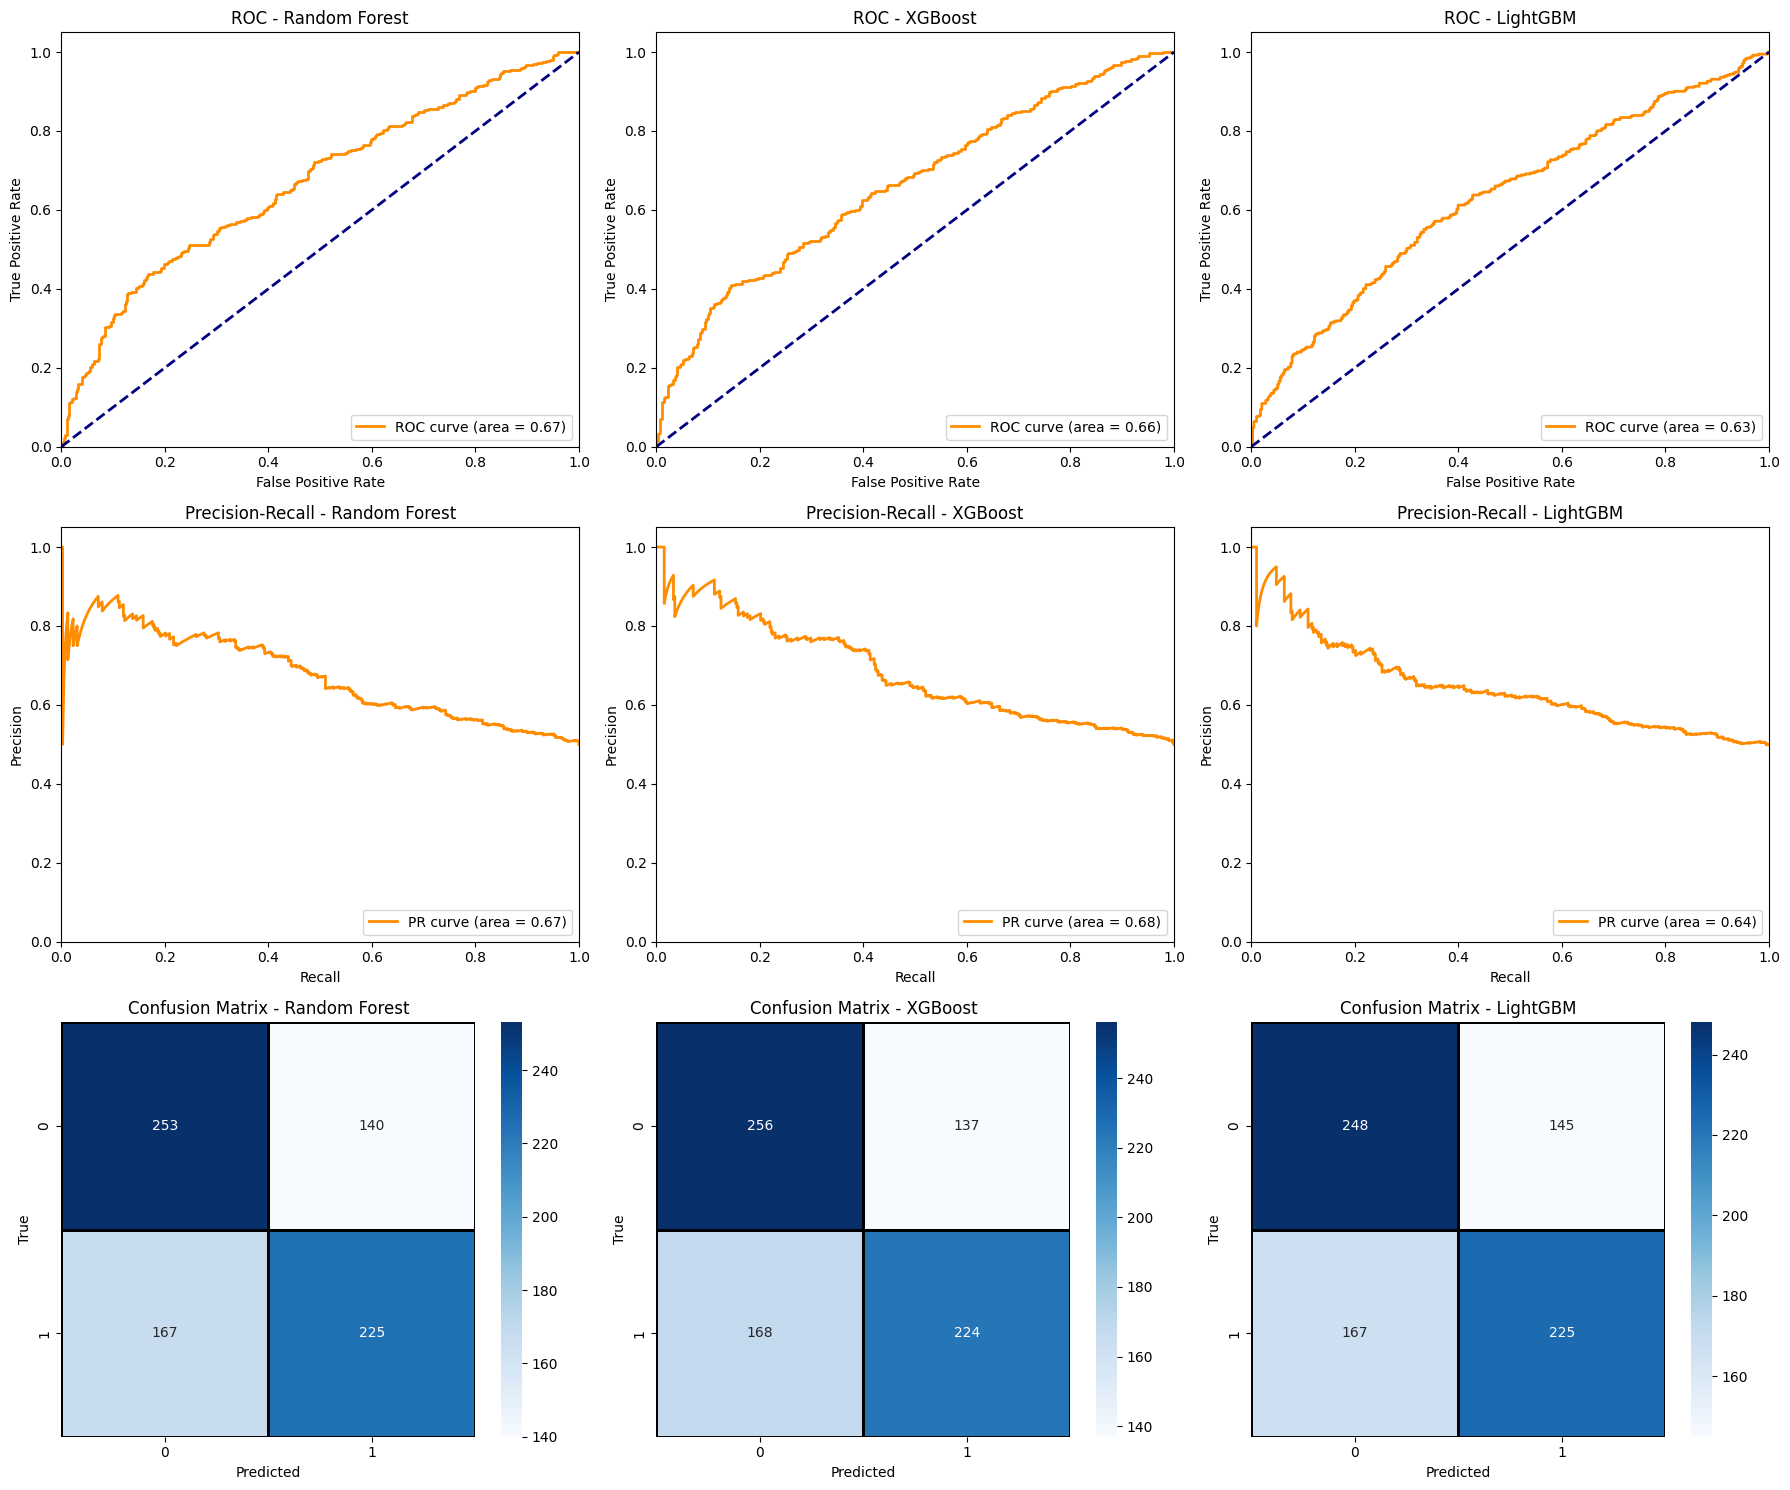

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.6089171974522293, 'Precision': 0.6164383561643836, 'Recall': 0.5739795918367347, 'F1 Score': 0.5944517833553501, 'ROC AUC': 0.6681077010957055}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.6114649681528662, 'Precision': 0.6204986149584487, 'Recall': 0.5714285714285714, 'F1 Score': 0.594953519256308, 'ROC AUC': 0.6638495092693565}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.6025477707006369, 'Precision': 0.6081081081081081, 'Recall': 0.5739795918367347, 'F1 Score': 0.5905511811023623, 'ROC AUC': 0.6300987952432882}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.6025477707006369,
 'Precision': 0.6081081081081081,
 'Recall': 0.5739795918367347,
 'F1 Score': 0.5905511811023623,
 'ROC AUC': 0.6300987952432882}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: XGBoost with Accuracy: 0.6115


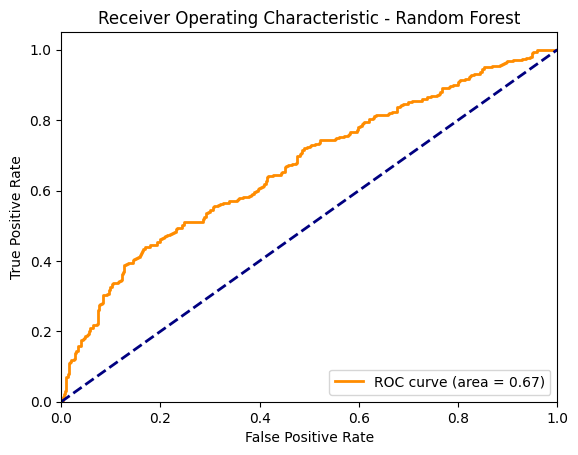

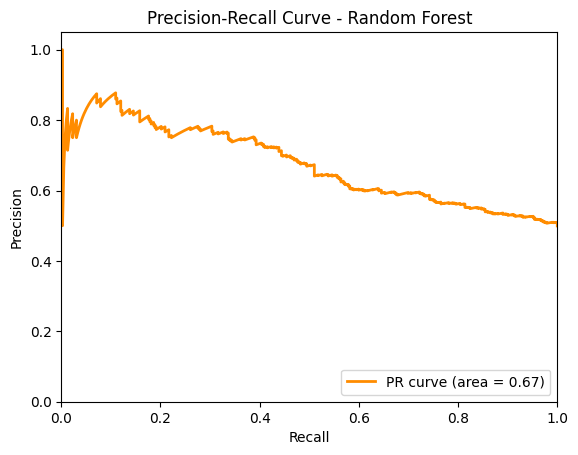

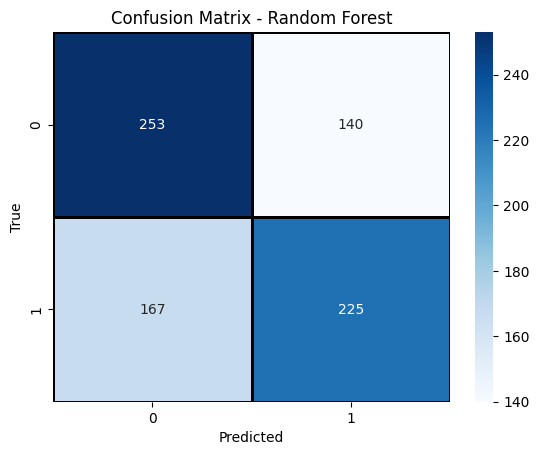

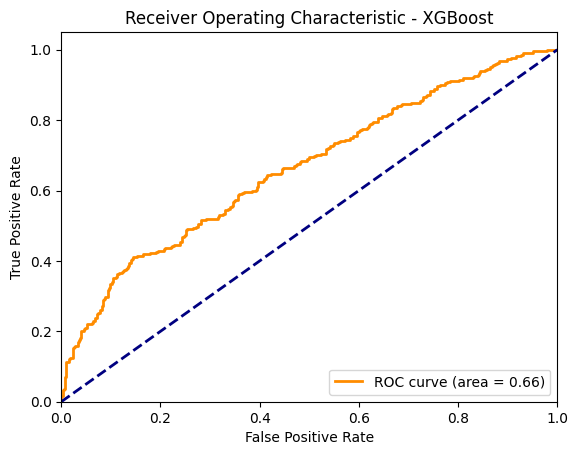

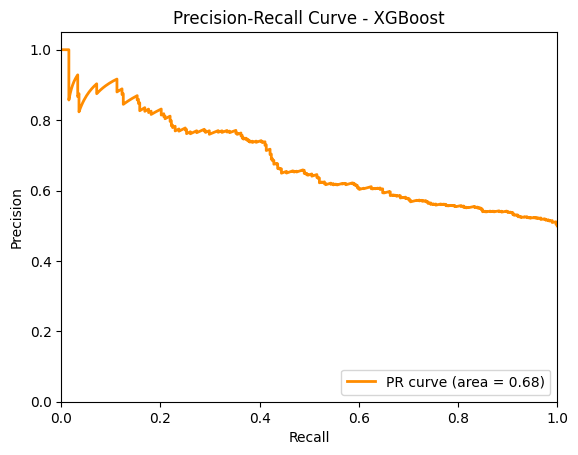

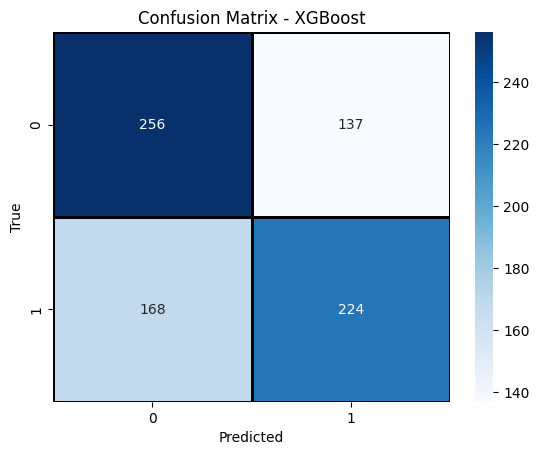

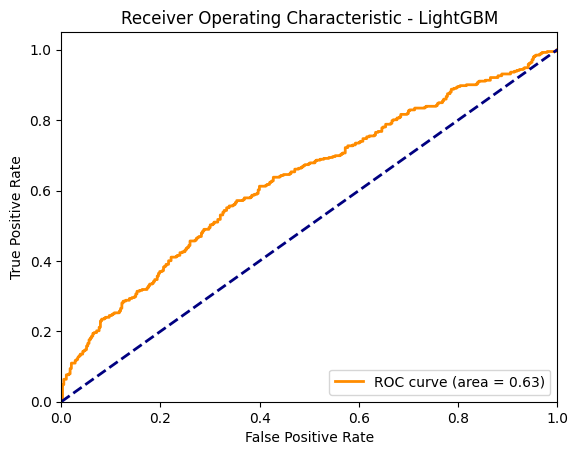

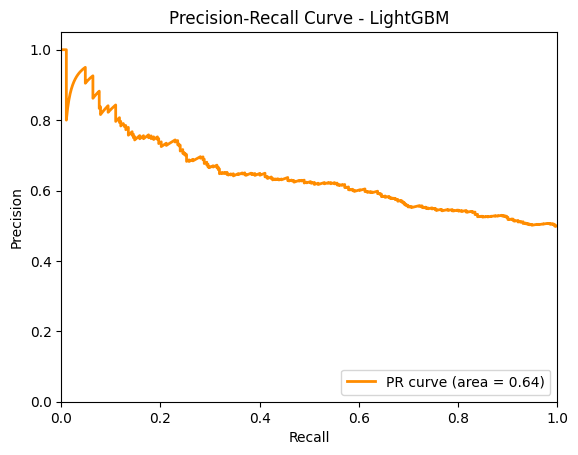

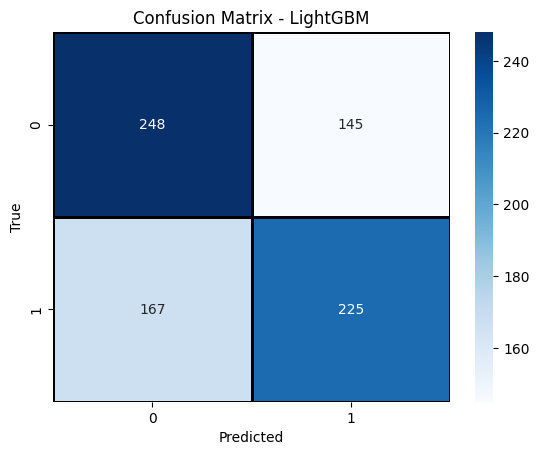

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

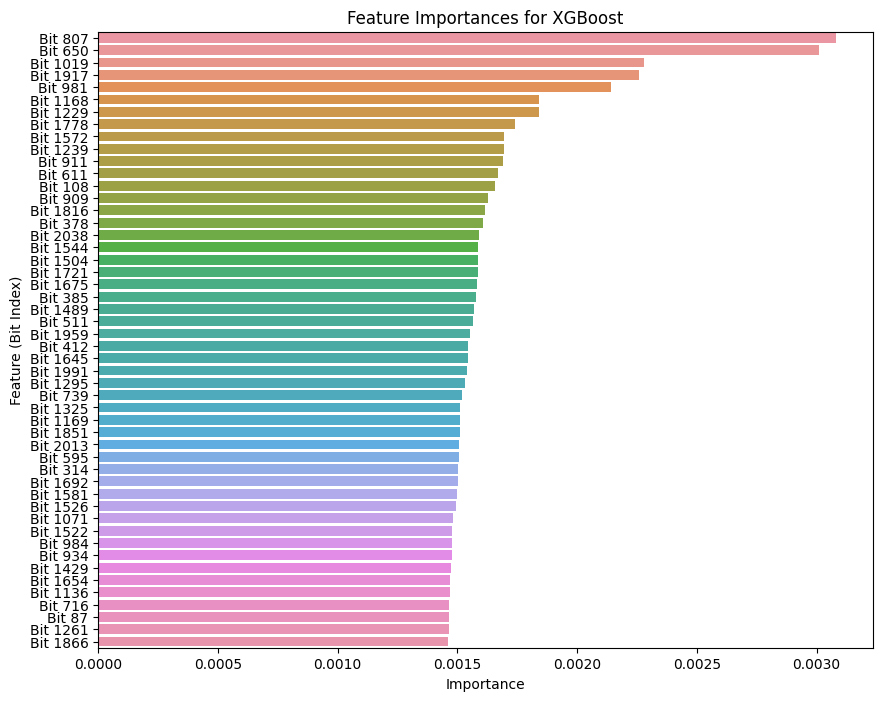

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
